In [1]:
!pip install -q numpy pandas mahotas opencv-python scikit-image scikit-learn tqdm tensorflow xgboost lightgbm

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import concurrent.futures as cf
import matplotlib.pyplot as plt
import mahotas
import random
import tensorflow as tf

from skimage import feature
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Constant

In [3]:
BASE_PATH = 'PROJECT_DATA'
IMG_SIZE = (600, 600)
SEED = 42

In [4]:
def set_tf_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_tf_seed(SEED)

# Load the data

In [5]:
df = pd.read_csv('ISIC_2017_Data_GroundTruth_Classification.csv')
df.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [6]:
df.describe()

,melanoma,seborrheic_keratosis
count,2000.000000,2000.000000
mean,0.187000,0.127000
std,0.390009,0.333056
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [7]:
def load_image(image_id):
    if os.path.exists(f'{BASE_PATH}/{image_id}.jpg'):
        image = cv2.imread(f'{BASE_PATH}/{image_id}.jpg')
        superpixels = cv2.imread(f'{BASE_PATH}/{image_id}_superpixels.png', cv2.IMREAD_GRAYSCALE)
        segmentation = cv2.imread(f'{BASE_PATH}/{image_id}_segmentation.png', cv2.IMREAD_GRAYSCALE)
        _, segmentation = cv2.threshold(segmentation, 127, 255, cv2.THRESH_BINARY)
        return image, superpixels, segmentation
    return None

In [8]:
# validate the image data

valid_image_ids = []
for idx, row in df.iterrows():
    image_id = row['image_id']
    if load_image(image_id) is not None:
        valid_image_ids.append(image_id)

df = df[df['image_id'].isin(valid_image_ids)]
df.reset_index(drop=True, inplace=True)


# Preprocess Image

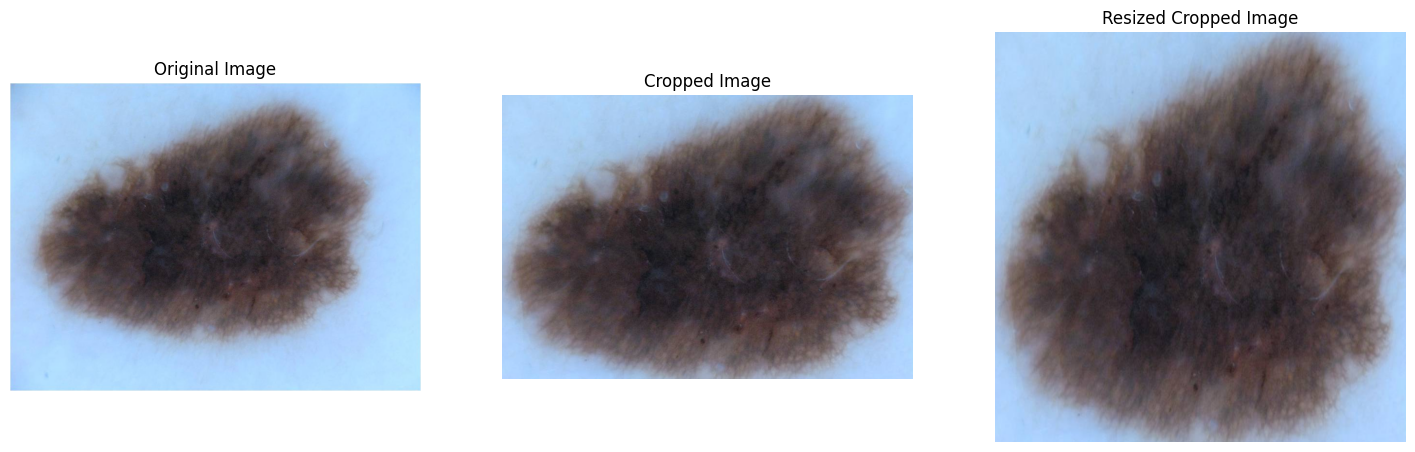

In [9]:
def get_bbox(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    return x, y, w, h

# Bounding box cropping
def crop_image(image, bbox):
    x, y, w, h = bbox
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

# Resize image
def resize_image(image, size):
    return cv2.resize(image, IMG_SIZE)

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
bbox = get_bbox(segmentation)
cropped_image = crop_image(image, bbox)
resized_cropped_image = resize_image(cropped_image, IMG_SIZE)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image[:,:,::-1])
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(cropped_image[:,:,::-1])
axs[1].set_title('Cropped Image')
axs[1].axis('off')
axs[2].imshow(resized_cropped_image[:,:,::-1])
axs[2].set_title('Resized Cropped Image')
axs[2].axis('off')
plt.show()

## ABCD Rule (Asymmetry, Border irregularity, Color irregularity and Differential structure)

### A: Asymmetry

A lesion is asymmetric if one half is not a mirror image of the other. In mathematical terms, this can be quantified by comparing the shape and area of the two halves of the lesion.

We calculate the asymmetry by:
1. Padding the lesion to a square shape for consistent processing.
2. Calculating the centroid of the lesion to ensure proper alignment.
3. Comparing the lesion with its 90-degree rotated version.
4. Quantifying the difference between the original and rotated lesion.

Given a binary lesion image $L$, the asymmetry score $A$ can be computed as:
$$
A = \frac{\sum \left| L - \text{rotate}(L, 90^\circ) \right|}{\sum L}
$$
where $\sum L$ is the total area of the lesion and $\sum \left| L - \text{rotate}(L, 90^\circ) \right|$ is the absolute difference in pixel values between the original and its rotated version. This ratio gives a measure of how asymmetric the lesion is.


In [10]:
# 1. Asymmetry
def calculate_asymmetry(binary_lesion):
    size = max(binary_lesion.shape)
    padded_lesion = np.zeros((size, size), dtype=binary_lesion.dtype)
    x_offset = (size - binary_lesion.shape[1]) // 2
    y_offset = (size - binary_lesion.shape[0]) // 2
    padded_lesion[
        y_offset:y_offset + binary_lesion.shape[0], x_offset:x_offset + binary_lesion.shape[1]
    ] = binary_lesion
    binary_lesion = padded_lesion
    moments = cv2.moments(binary_lesion)
    if moments['m00'] == 0:
        return 0
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])

    rotated = np.rot90(binary_lesion)
    diff = cv2.absdiff(binary_lesion, rotated)
    asymmetry_score = np.sum(diff) / np.sum(binary_lesion)
    return asymmetry_score

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
bbox = get_bbox(segmentation)
lesion_color = crop_image(image, bbox)
lesion_binary = crop_image(segmentation, bbox)

asymmetry_score = calculate_asymmetry(lesion_binary)
print(f"Asymmetry Score: {asymmetry_score}")



Asymmetry Score: 0.5948059492103157


### B: Border Irregularity

Border irregularity is assessed by examining the edges of the lesion for uneven or notched edges. 

Given the contour of the lesion, we calculate its actual perimeter $P$ and the expected perimeter $P_{exp}$ based on its bounding box. The border irregularity score $B$ is then:
$$
B = \frac{P}{P_{exp}}
$$
where $P$ is the actual perimeter of the lesion contour and $P_{exp}$ is the expected perimeter of the bounding box, computed as $2 \times (\text{width} + \text{height})$.

If the expected perimeter is zero, indicating an invalid or extremely small bounding box, the irregularity score is set to zero.




In [11]:
# 2. Border Irregularity
def calculate_border_irregularity(contour):
    perimeter = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    expected_perimeter = 2 * (w + h)
    border_irregularity_score = perimeter / expected_perimeter if expected_perimeter > 0 else 0
    return border_irregularity_score

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


border_irregularity_score = calculate_border_irregularity(contours[0])
print(f"Border Irregularity Score: {border_irregularity_score}")

Border Irregularity Score: 0.9007261656951108


### C: Color Irregularity

Color irregularity is assessed by examining the variety and distribution of colors within the lesion. Melanomas often have multiple shades of brown, black, red, white, or blue.


To quantify color irregularity, we can analyze the variation in color channels using the CIE LAB color space, which is designed to approximate human vision. This space separates the image into Lightness (L), green-red (A), and blue-yellow (B) components. The irregularity can be evaluated by calculating the standard deviation of these channels and then averaging them. The color irregularity score $C$ can be computed as:
$$
C = \frac{\sigma(L) + \sigma(A) + \sigma(B)}{3}
$$
where $\sigma(L)$, $\sigma(A)$, and $\sigma(B)$ are the standard deviations of the L, A, and B channels, respectively.


In [12]:
# 3. Color Irregularity
def calculate_color_irregularity(image_rgb):
    image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l_std, a_std, b_std = np.std(image_lab[..., 0]), np.std(image_lab[..., 1]), np.std(image_lab[..., 2])
    color_irregularity_score = np.mean([l_std, a_std, b_std])
    return color_irregularity_score

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
bbox = get_bbox(segmentation)
lesion_color = crop_image(image, bbox)
lesion_binary = crop_image(segmentation, bbox)

color_irregularity_score = calculate_color_irregularity(lesion_color)
print(f"Color Irregularity Score: {color_irregularity_score}")



Color Irregularity Score: 27.258190515671146


### D: Differential Structure

Differential structure assesses the presence of various textures and patterns within the lesion. High variation in structure can be indicative of malignancy. The Sobel operator is used to compute the gradient of the image intensity, emphasizing areas with significant changes.

Using the Sobel operator, the gradients in the x and y directions ($G_x$ and $G_y$) are computed. The magnitude of the gradient $G$ at each pixel can be expressed as:
$$
G = \sqrt{G_x^2 + G_y^2}
$$
The differential structure score $D$ is then the mean value of $G$ over all pixels:
$$
D = \frac{1}{N} \sum_{i=1}^N G_i
$$
where $N$ is the total number of pixels in the lesion area.

In [13]:
# 4. Differential Structure
def calculate_differential_structure(image_binary):
    sobel_x = cv2.Sobel(image_binary, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image_binary, cv2.CV_64F, 0, 1, ksize=5)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    differential_structure_score = np.mean(sobel_magnitude)
    return differential_structure_score

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
bbox = get_bbox(segmentation)
lesion_color = crop_image(image, bbox)
lesion_binary = crop_image(segmentation, bbox)

differential_structure_score = calculate_differential_structure(lesion_binary)
print(f"Differential Structure Score: {differential_structure_score}")

Differential Structure Score: 139.8789327688785


## Additional Contour Descriptors

We will compute each of the following:

1. **Area** ($A$):
   - The area enclosed by the contour.
   $$
   A = \text{cv2.contourArea}(\text{contour})
   $$

2. **Perimeter** ($P$):
   - The total length of the contour.
   $$
   P = \text{cv2.arcLength}(\text{contour}, \text{True})
   $$

3. **Aspect Ratio** ($AR$):
   - The ratio of the width to the height of the bounding rectangle.
   $$
   AR = \frac{w_{\text{rect}}}{h_{\text{rect}}}
   $$

4. **Extent** ($E$):
   - The ratio of the contour area to the area of the bounding rectangle.
   $$
   E = \frac{A}{w \times h}
   $$

5. **Solidity** ($S$):
   - The ratio of the contour area to the convex hull area.
   $$
   S = \frac{A}{\text{hull\_area}}
   $$

6. **Equivalent Diameter** ($D$):
   - The diameter of a circle with the same area as the contour.
   $$
   D = \sqrt{\frac{4 \times A}{\pi}}
   $$

7. **Orientation** ($\theta$):
   - The angle of the major axis of the ellipse that has the same second-moments as the contour.
   $$
   \theta = \text{cv2.fitEllipse}(\text{contour})[2] \quad \text{(if contour has at least 5 points)}
   $$

8. **Eccentricity** ($e$):
   - A measure of how much the shape of the ellipse deviates from being circular.
   $$
   e = \sqrt{1 - \left(\frac{\text{minor axis length}}{\text{major axis length}}\right)^2}
   $$

9. **Convexity** ($C$):
   - The ratio of the perimeter to the convex hull perimeter.
   $$
   C = \frac{P}{\text{cv2.arcLength}(\text{hull}, \text{True})}
   $$

10. **Circularity** ($C_{\text{ir}}$):
    - A measure of how close the contour is to being a circle.
    $$
    C_{\text{ir}} = \frac{4 \times \pi \times A}{P^2}
    $$

11. **Rectangularity** ($R$):
    - The ratio of the area to the area of the bounding rectangle.
    $$
    R = \frac{A}{w_{\text{rect}} \times h_{\text{rect}}}
    $$

12. **Hu Moments** ($H_1, H_2, \ldots, H_7$):
    - Invariant moments that provide a measure of the shape.
    $$
    \text{Hu Moments} = \text{cv2.HuMoments}(\text{cv2.moments}(\text{contour})).\text{flatten}()
    $$

13. **Zernike Moments** ($Z_1, Z_2, \ldots, Z_{25}$):
    - Shape descriptors derived from orthogonal Zernike polynomials.
    $$
    Z_i = \text{mahotas.features.zernike\_moments}(\text{binary\_image}, \text{radius}, \text{degree})
    $$

14. **Haralick Features - Contrast** ($H_C$):
    - A texture measure based on the intensity contrast between a pixel and its neighbor.
    $$
    H_C = \text{graycoprops}(\text{GLCM}, \text{'contrast'})[0, 0]
    $$

15. **Haralick Features - Correlation** ($H_{COR}$):
    - A measure of how correlated a pixel is to its neighbor.
    $$
    H_{COR} = \text{graycoprops}(\text{GLCM}, \text{'correlation'})[0, 0]
    $$

16. **Haralick Features - Energy** ($H_E$):
    - A measure of the uniformity or repeatability of pixel intensity pairs.
    $$
    H_E = \text{graycoprops}(\text{GLCM}, \text{'energy'})[0, 0]
    $$

17. **Haralick Features - Homogeneity** ($H_H$):
    - A measure of how close the distribution of elements in the GLCM is to the GLCM diagonal.
    $$
    H_H = \text{graycoprops}(\text{GLCM}, \text{'homogeneity'})[0, 0]
    $$


In [14]:
def compute_contour_descriptors(contours, binary_image, gray_image, w, h):
    contour = contours[0]
    # Basic descriptors
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Convex Hull
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    convexity = perimeter / cv2.arcLength(hull, True) if cv2.arcLength(hull, True) > 0 else 0

    # Circularity
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    
    # Rectangularity
    x_rect, y_rect, w_rect, h_rect = cv2.boundingRect(contour)
    rectangularity = area / (w_rect * h_rect) if w_rect * h_rect > 0 else 0

    # Aspect Ratio
    aspect_ratio = float(w_rect) / h_rect

    # Extent
    extent = float(area) / (w * h)
    
    # Solidity
    solidity = float(area) / hull_area if hull_area > 0 else 0
    
    # Equivalent Diameter
    equi_diameter = np.sqrt(4 * area / np.pi)
    
    # Orientation
    if len(contour) >= 5:  # FitEllipse requires at least 5 points
        (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
    else:
        angle = 0
    
    # Eccentricity (using fitted ellipse)
    if len(contour) >= 5:  # FitEllipse requires at least 5 points
        ellipse = cv2.fitEllipse(contour)
        (center, axes, orientation) = ellipse
        majoraxis_length = max(axes)
        minoraxis_length = min(axes)
        eccentricity = np.sqrt(1 - (minoraxis_length / majoraxis_length)**2)
    else:
        eccentricity = 0
    
    # Hu Moments
    hu_moments = cv2.HuMoments(cv2.moments(contour)).flatten()
    hu_moments = hu_moments[:7]
    while len(hu_moments) < 7:
        hu_moments = np.append(hu_moments, 0)
    hu_moments.tolist()

    # Zernike Moments (using Mahotas)
    # Assuming the radius is approximately the bounding box size divided by 2
    radius = max(w_rect, h_rect) // 2
    center = (x_rect + w_rect // 2, y_rect + h_rect // 2)
    zernike_moments = mahotas.features.zernike_moments(binary_image, radius=radius, degree=8)
    zernike_moments = zernike_moments[:25]
    while len(zernike_moments) < 25:
        zernike_moments = np.append(zernike_moments, 0)
    zernike_moments.tolist()

    # Haralick Features (texture analysis)
    glcm = feature.graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    haralick_features_contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
    haralick_features_correlation = feature.graycoprops(glcm, 'correlation')[0, 0]
    haralick_features_energy = feature.graycoprops(glcm, 'energy')[0, 0]
    haralick_features_homogeneity = feature.graycoprops(glcm, 'homogeneity')[0, 0]
    
    descriptors = [
        np.log(area),
        np.log(perimeter),
        aspect_ratio,
        extent,
        solidity,
        np.log(equi_diameter),
        angle/360,
        eccentricity,
        convexity,
        circularity,
        rectangularity,
        haralick_features_contrast/255,
        haralick_features_correlation,
        haralick_features_energy,
        haralick_features_homogeneity
    ]
    descriptors.extend(hu_moments)
    descriptors.extend(zernike_moments)
    return descriptors

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
x, y, w, h = get_bbox(segmentation)

descriptors = compute_contour_descriptors(contours, segmentation, gray_image, w, h)
# Print the descriptors
for desc in descriptors:
    print(desc)

12.804431010351927
7.858209939953532
1.4421768707482994
0.7296600243871133
0.9685393617361119
6.522997742811208
0.21197547912597656
0.744913244970587
1.1291780957050137
0.6832020591145656
0.7296600243871133
0.02873950788834932
0.9991581389041616
0.07524571526670155
0.6198022332063071
0.17732941191082363
0.005090377865005834
0.00030871089615882425
1.4610983567363535e-05
7.949589867188334e-10
8.133003440982395e-07
-5.752916212116965e-10
0.318309886185492
0.0054826500212021845
0.2787281345156554
0.1310199410700025
0.030508831506922622
0.05428066045166282
0.061607810345520986
0.05213920107531534
0.03913552154572352
0.044776839593285975
0.028704548721058133
0.03919591004271223
0.05879526695913209
0.09442523537854815
0.03927585009383778
0.019702400015401262
0.025896109042089322
0.010122296763081358
0.002013675268403939
0.007019906140313047
0.007591863253750283
0.024402438244933284
0.04412412999955992
0.029551772140496466
0.017209489276890554


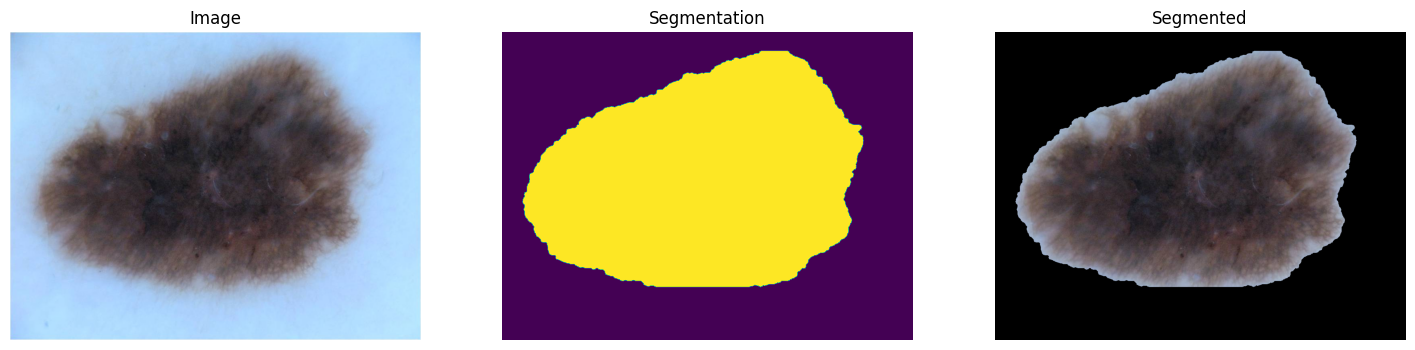

In [15]:
def segment_image(image, segmentation):
    binary = np.zeros_like(image)
    binary = np.expand_dims(segmentation == 255, axis=-1)
    return image * binary

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
segmented_image = segment_image(image, segmentation)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image[:,:,::-1])
axs[0].set_title('Image')
axs[0].axis('off')
axs[1].imshow(segmentation)
axs[1].set_title('Segmentation')
axs[1].axis('off')
axs[2].imshow(segmented_image[:,:,::-1])
axs[2].set_title('Segmented')
axs[2].axis('off')
plt.show()

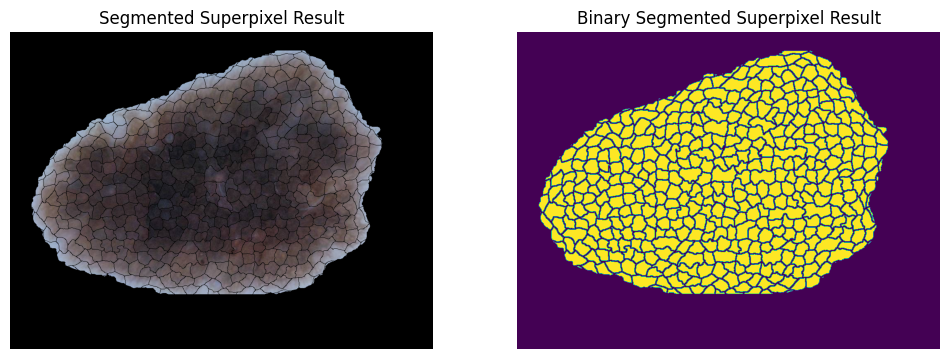

In [16]:
def segment_superpixel(image, superpixels, segmentation): 
    unique_pixel = np.unique(superpixels)
    result = np.zeros_like(superpixels)
    def segment_each(pixel):
        segmented = (255*(superpixels == pixel)).astype(np.uint8)
        return cv2.Canny(segmented, 0, 255)
    with cf.ThreadPoolExecutor() as executor:    
        results = executor.map(segment_each, unique_pixel)
    for res in results:
        result += res
    binary = np.expand_dims(result == 0, axis=-1)
    segmentation = np.expand_dims(segmentation == 255, axis=-1)
    res1 = image * binary
    res2 = (segmentation * binary).astype(np.uint8)
    res2 = cv2.erode(res2,np.ones((3,3),np.uint8))
    return res1, res2

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
segmented_image = segment_image(image, segmentation)
res1, res2 = segment_superpixel(segmented_image, superpixels, segmentation)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(res1[:,:,::-1])
axs[0].set_title('Segmented Superpixel Result')
axs[0].axis('off')
axs[1].imshow(res2)
axs[1].set_title('Binary Segmented Superpixel Result')
axs[1].axis('off')
plt.show()

## Average Color Each Superpixels Segment

To compute the average color for each superpixel segment in an image, we utilize the `calculate_average_color` function. This function performs the following steps:

1. **Segment Identification**:
   - It identifies connected components (superpixels) in the segmented image using `cv2.connectedComponentsWithStats`.
   
2. **Color Computation**:
   - For each superpixel, it computes the average color by summing up pixel colors and dividing by the number of pixels.

3. **Multithreading**:
   - Utilizes `ThreadPoolExecutor` for parallel processing to enhance efficiency.

4. **Normalization**:
   - Normalizes the resulting color values to a range of [0, 1] by dividing by 255.


In [17]:
def calculate_average_color(image, segmented):
    analysis = cv2.connectedComponentsWithStats(segmented, connectivity=4, ltype=cv2.CV_32S)
    (totalLabels, label_ids, values, centroids) = analysis
    
    average_colors = np.zeros((384, 3), dtype=np.float32)
    
    def compute_average_color(label):
        component_mask = (label_ids == label)
        masked_colors_sum = np.sum(image[component_mask], axis=0)
        num_pixels = component_mask.sum()
        if num_pixels > 0:
            return label - 1, masked_colors_sum / num_pixels  
        return label - 1, np.array([0, 0, 0], dtype=np.float32)  
    
    
    with cf.ThreadPoolExecutor() as executor:    
        results = executor.map(compute_average_color, range(1, totalLabels))
        for idx, (label_idx, avg_color) in enumerate(results):
            if label_idx < 384:
                average_colors[label_idx] = avg_color
            else:
                break
    
    flattened_colors = average_colors.flatten()/255
    return flattened_colors

image, superpixels, segmentation = load_image(df.iloc[0]['image_id'])
segmented_image = segment_image(image, segmentation)
res1, res2 = segment_superpixel(segmented_image, superpixels, segmentation)
avg_color = calculate_average_color(image, res2)

print('Average Color:', avg_color)

Average Color: [0.74081725 0.6499626  0.58803576 ... 0.43871385 0.4377981  0.48927003]


## Preprocess and prepare dataset

In [18]:
def feature_extraction(image_id):
    out = load_image(image_id)
    if out is None:
        return None
    # Load and segment the image
    image, superpixels, segmentation = out
    segmented_image = segment_image(image, segmentation)
    res1, res2 = segment_superpixel(segmented_image, superpixels, segmentation)

    # Crop the lession
    bbox = get_bbox(segmentation)
    cropped_image = crop_image(image, bbox)
    cropped_segmentation = crop_image(segmentation, bbox)
    cropped_segmented_image = crop_image(segmented_image, bbox)
    cropped_res1 = crop_image(res1, bbox)
    cropped_res2 = crop_image(res2, bbox)



    # 1. Asymmetry
    asymmetry_score = calculate_asymmetry(cropped_segmentation)

    # 2. Border Irregularity
    contours, _ = cv2.findContours(cropped_segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    border_irregularity_score = calculate_border_irregularity(contours[0])

    # 3. Color Irregularity
    color_irregularity_score = calculate_color_irregularity(cropped_image)

    # 4. Differential Structure
    differential_structure_score = calculate_differential_structure(cropped_segmentation)

    # 5. Contour Descriptors
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    w, h = cropped_segmentation.shape
    contour_descriptors = compute_contour_descriptors(contours, cropped_segmentation, gray_image, w, h)

    # 6. Average Color each superpixel
    resized_image = resize_image(image, IMG_SIZE)
    resized_cropped_res2 = resize_image(cropped_res2, IMG_SIZE)
    avg_color = calculate_average_color(resized_image, resized_cropped_res2)


    features = [
        asymmetry_score, border_irregularity_score, color_irregularity_score, differential_structure_score, contour_descriptors, avg_color
    ]
    features = [np.asarray(feat).flatten() for feat in features]
    return np.concatenate(features, axis=0).flatten()

In [19]:
# Test the feature extraction function
features = feature_extraction(df.iloc[0]['image_id'])
print('Features Shape:', features.shape)

Features Shape: (1203,)


In [20]:
X = []
y = []
for img_id, label in tqdm(zip(df['image_id'], df['melanoma']), total=len(df)):
    features = feature_extraction(img_id)
    if features is None:
        continue
    X.append(features)
    y.append(label)
    
X = np.asarray(X)
y = np.asarray(y).astype(np.uint8)

100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


# Train the classifier

In [21]:
def validate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)
    
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    print(f"F1 Score: {f1 :.6f}")
    print(f"Accuracy: {acc :.6f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(confusion)
    print("\n")

In [22]:
def compare_image_with_label(model, image_id, actual_label):
    features = feature_extraction(image_id)
    if features is None:
        print("No features extracted for image:", image_id)
        return
    
    feature_array = np.array([features])
    
    predicted_label = model.predict(feature_array)
    predicted_label = (predicted_label >= 0.5).astype(int)
    
    comparison_result = "Correct" if predicted_label == actual_label else "Incorrect"
    
    print(f"Image ID: {image_id} - Actual Label: {actual_label}, Predicted Label: {predicted_label}, Result: {comparison_result}")


## Train test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 1203), (40, 1203), (160,), (40,))

## Logistic Regression

In [24]:
log_reg = LogisticRegression(random_state=SEED, n_jobs=-1)
log_reg.fit(X_train, y_train)

validate_model(log_reg, X_test, y_test)

print('Comparing 5 random images with their actual labels:')
for idx in random.sample(range(len(df)), 5):
    image_id = df.iloc[idx]['image_id']
    actual_label = df.iloc[idx]['melanoma']
    compare_image_with_label(log_reg, image_id, actual_label)


/Users/mdaniyalk/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.555556
Accuracy: 0.600000
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        21
           1       0.59      0.53      0.56        19

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40

Confusion Matrix:
[[14  7]
 [ 9 10]]
Image ID: ISIC_0000294 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000029 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000007 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000463 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000075 - Actual Label: 0.0, Predicted Label: [0], Result: Correct


## XGBoost Classifier

In [25]:
xgb_model = XGBClassifier(seed=SEED)
xgb_model.fit(X_train, y_train)
validate_model(xgb_model, X_test, y_test)

print('Comparing 5 random images with their actual labels:')
for idx in random.sample(range(len(df)), 5):
    image_id = df.iloc[idx]['image_id']
    actual_label = df.iloc[idx]['melanoma']
    compare_image_with_label(log_reg, image_id, actual_label)


F1 Score: 0.594595
Accuracy: 0.625000
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65        21
           1       0.61      0.58      0.59        19

    accuracy                           0.62        40
   macro avg       0.62      0.62      0.62        40
weighted avg       0.62      0.62      0.62        40

Confusion Matrix:
[[14  7]
 [ 8 11]]
Image ID: ISIC_0000066 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000061 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000037 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000445 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000027 - Actual Label: 0.0, Predicted Label: [0], Result: Correct


## LGBM Classifier

In [26]:
lgbm_model = LGBMClassifier(seed=SEED)
lgbm_model.fit(X_train, y_train)
validate_model(lgbm_model, X_test, y_test)

print('Comparing 5 random images with their actual labels:')
for idx in random.sample(range(len(df)), 5):
    image_id = df.iloc[idx]['image_id']
    actual_label = df.iloc[idx]['melanoma']
    compare_image_with_label(log_reg, image_id, actual_label)


F1 Score: 0.578947
Accuracy: 0.600000
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        21
           1       0.58      0.58      0.58        19

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40

Confusion Matrix:
[[13  8]
 [ 8 11]]
Image ID: ISIC_0000307 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000463 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000161 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000023 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000276 - Actual Label: 1.0, Predicted Label: [1], Result: Correct


## Support Vector Machine (SVM)

In [27]:
svm_model = SVC(random_state=SEED)
svm_model.fit(X_train, y_train)
validate_model(svm_model, X_test, y_test)

print('Comparing 5 random images with their actual labels:')
for idx in random.sample(range(len(df)), 5):
    image_id = df.iloc[idx]['image_id']
    actual_label = df.iloc[idx]['melanoma']
    compare_image_with_label(log_reg, image_id, actual_label)



F1 Score: 0.634146
Accuracy: 0.625000
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        21
           1       0.59      0.68      0.63        19

    accuracy                           0.62        40
   macro avg       0.63      0.63      0.62        40
weighted avg       0.63      0.62      0.62        40

Confusion Matrix:
[[12  9]
 [ 6 13]]
Image ID: ISIC_0000121 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000009 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000008 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000024 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000057 - Actual Label: 0.0, Predicted Label: [0], Result: Correct


## Naive Bayes

In [28]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
validate_model(nb_model, X_test, y_test)

print('Comparing 5 random images with their actual labels:')
for idx in random.sample(range(len(df)), 5):
    image_id = df.iloc[idx]['image_id']
    actual_label = df.iloc[idx]['melanoma']
    compare_image_with_label(log_reg, image_id, actual_label)


F1 Score: 0.736842
Accuracy: 0.750000
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        21
           1       0.74      0.74      0.74        19

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40

Confusion Matrix:
[[16  5]
 [ 5 14]]
Image ID: ISIC_0000063 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000150 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000281 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000007 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000165 - Actual Label: 1.0, Predicted Label: [1], Result: Correct


## K-Nearest Neighbors (KNN)

In [29]:
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_model.fit(X_train, y_train)
validate_model(knn_model, X_test, y_test)

print('Comparing 5 random images with their actual labels:')
for idx in random.sample(range(len(df)), 5):
    image_id = df.iloc[idx]['image_id']
    actual_label = df.iloc[idx]['melanoma']
    compare_image_with_label(log_reg, image_id, actual_label)



F1 Score: 0.650000
Accuracy: 0.650000
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        21
           1       0.62      0.68      0.65        19

    accuracy                           0.65        40
   macro avg       0.65      0.65      0.65        40
weighted avg       0.65      0.65      0.65        40

Confusion Matrix:
[[13  8]
 [ 6 13]]
Image ID: ISIC_0000052 - Actual Label: 0.0, Predicted Label: [0], Result: Correct
Image ID: ISIC_0000413 - Actual Label: 1.0, Predicted Label: [0], Result: Incorrect
Image ID: ISIC_0000298 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000393 - Actual Label: 1.0, Predicted Label: [1], Result: Correct
Image ID: ISIC_0000161 - Actual Label: 1.0, Predicted Label: [1], Result: Correct


## Neural Network

In [30]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))
validate_model(nn_model, X_test, y_test)

print('Comparing 5 random images with their actual labels:')
for idx in random.sample(range(len(df)), 5):
    image_id = df.iloc[idx]['image_id']
    actual_label = df.iloc[idx]['melanoma']
    compare_image_with_label(log_reg, image_id, actual_label)


Epoch 1/30
5/5 [==============================] - 0s 26ms/step - loss: 2.0846 - accuracy: 0.5125 - val_loss: 1.0406 - val_accuracy: 0.5250
Epoch 2/30
5/5 [==============================] - 0s 5ms/step - loss: 1.9130 - accuracy: 0.5063 - val_loss: 1.8582 - val_accuracy: 0.4750
Epoch 3/30
5/5 [==============================] - 0s 5ms/step - loss: 1.4007 - accuracy: 0.5188 - val_loss: 0.8920 - val_accuracy: 0.5250
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 1.4658 - accuracy: 0.5500 - val_loss: 0.7467 - val_accuracy: 0.5000
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 0.9334 - accuracy: 0.5813 - val_loss: 1.1334 - val_accuracy: 0.4000
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 1.0130 - accuracy: 0.5625 - val_loss: 0.8372 - val_accuracy: 0.3750
Epoch 7/30
5/5 [==============================] - 0s 5ms/step - loss: 0.9375 - accuracy: 0.5562 - val_loss: 0.7122 - val_accuracy: 0.6000
Epoch 8/30
5/5 [=================

## Classifier Result

| Classifier | F1 Score | Accuracy | Precision (Class 0) | Recall (Class 0) | Precision (Class 1) | Recall (Class 1) |
|------------------------|----------|----------|---------------------|------------------|---------------------|------------------|
| Logistic Regression | 0.556 | 0.600 | 0.61 | 0.67 | 0.59 | 0.53 |
| XGBoost Classifier | 0.595 | 0.625 | 0.64 | 0.67 | 0.61 | 0.58 |
| LGBM Classifier | 0.579 | 0.600 | 0.62 | 0.62 | 0.58 | 0.58 |
| SVM | 0.634 | 0.625 | 0.67 | 0.57 | 0.59 | 0.68 |
| Naive Bayes | 0.737 | **0.750** | 0.76 | **0.76** | **0.74** | **0.74** |
| K-Nearest Neighbors | 0.650 | 0.650 | 0.68 | 0.62 | 0.62 | 0.68 |
| Neural Network | **0.744** | 0.725 | **0.81** | 0.62 | 0.67 | 0.84 |

- **F1 Score**: Harmonic mean of precision and recall, providing a balance between the two metrics.
- **Accuracy**: Proportion of correctly classified instances.
- **Precision**: Proportion of true positives out of all positive predictions.
- **Recall**: Proportion of true positives that were correctly identified.


# Conclusion

- **Feature Importance**: Each feature contributes differently to classification accuracy. Asymmetry, color irregularity, and differential structure scores play crucial roles in distinguishing melanomas.
- **Classifier Performance**: Naive Bayes performed the best overall, achieving the highest accuracy and F1 score, closely followed by the neural network.

In conclusion, leveraging a combination of these features and classifiers can significantly aid in accurate and reliable melanoma detection.